# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the data from a CSV file
rws = pd.read_csv('/Users/antoinem/Desktop/project-ada/3projet/data/datareview.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [2]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

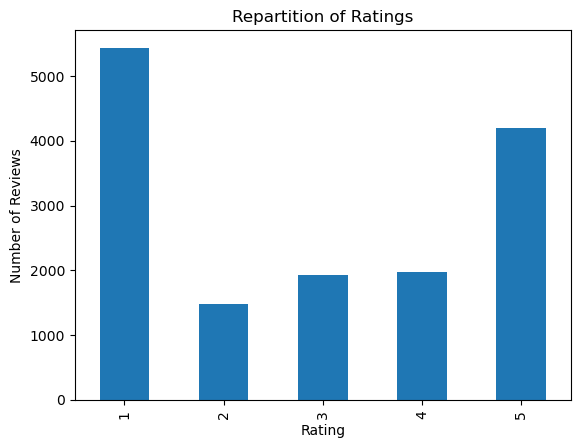

In [3]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


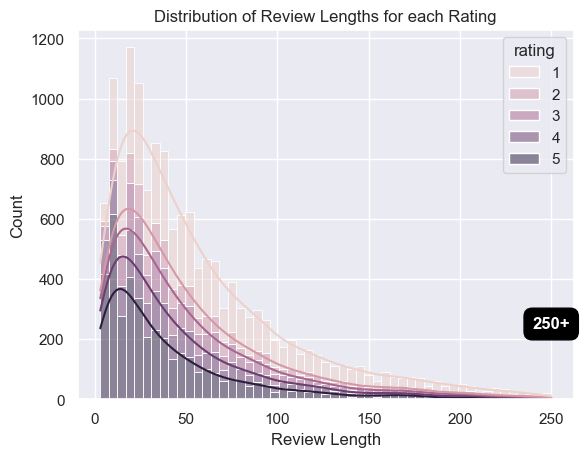

In [4]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [5]:
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']
print(longest_review)


When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [6]:
rws.drop('review_length', axis=1, inplace=True)

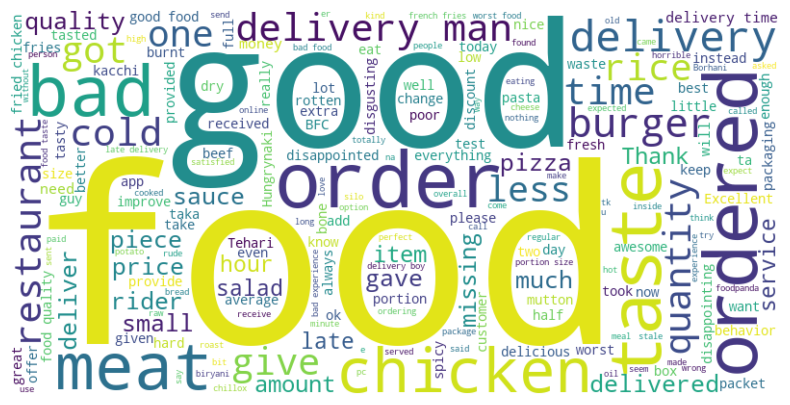

In [7]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [8]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3, if any

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

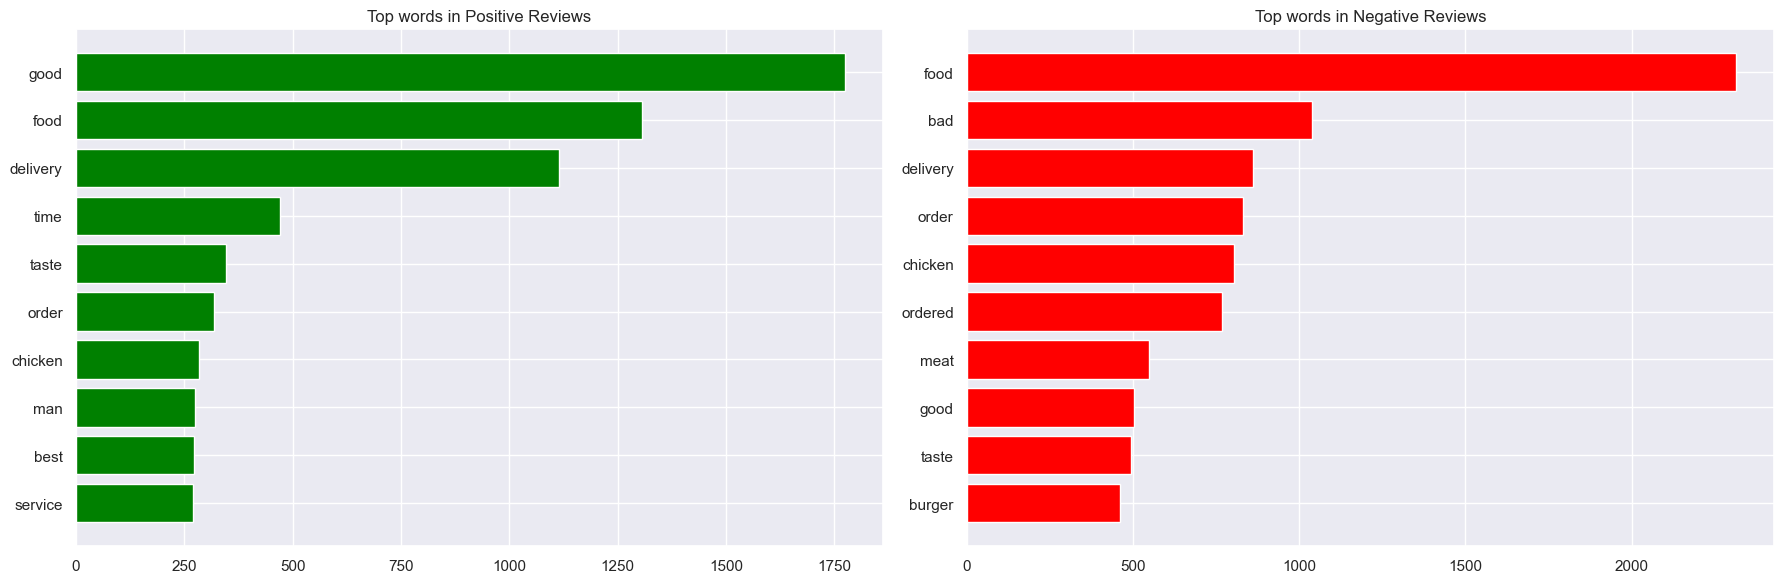

In [9]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


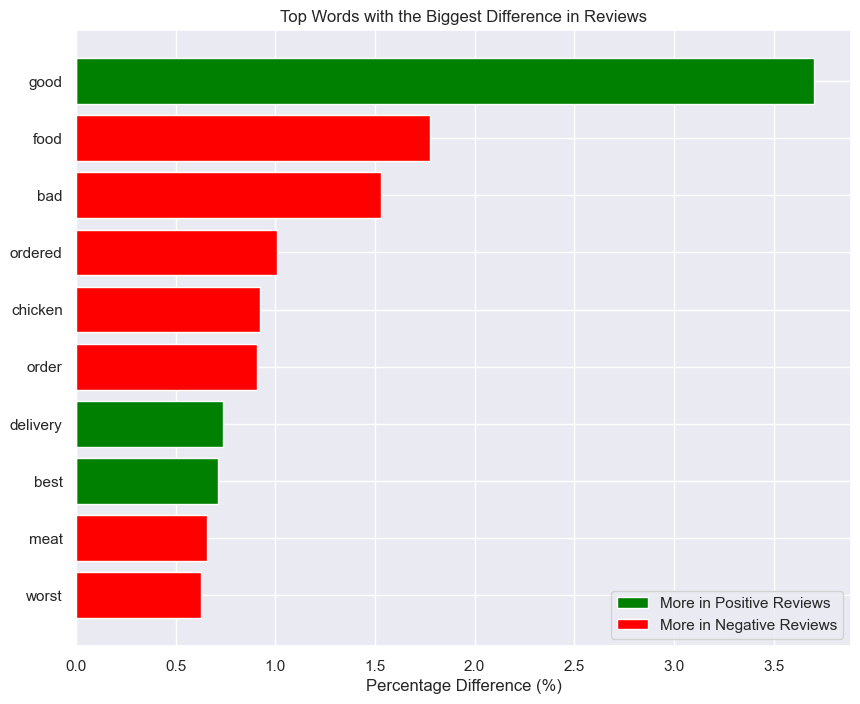

In [10]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [11]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [12]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [13]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [14]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

## Naive Bayes 

In [15]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0c = MultinomialNB()
model_0c.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0c.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0c_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0c_accuracy = accuracy_score(cy_test, cy_pred)
m0c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Change average method as appropriate
m0c_recall = recall_score(cy_test, cy_pred, average='weighted')
m0c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0c_accuracy:.2%}", f"{m0c_precision:.3f}", f"{m0c_recall:.3f}", f"{m0c_f1:.3f}", f"{m0c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000001 seconds


In [16]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0r = MultinomialNB()
model_0r.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0r.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0r_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0r_accuracy = accuracy_score(ry_test, ry_pred)
m0r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use weighted to account for label imbalance
m0r_recall = recall_score(ry_test, ry_pred, average='weighted')
m0r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0r_accuracy:.2%}", f"{m0r_precision:.3f}", f"{m0r_recall:.3f}", f"{m0r_f1:.3f}", f"{m0r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


In [17]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model
store_results('Model_0c', m0c_accuracy, m0c_precision, m0c_recall, m0c_f1, m0c_time_per_instance)

# Store the results for the raw text model
store_results('Model_0r', m0r_accuracy, m0r_precision, m0r_recall, m0r_f1, m0r_time_per_instance)

# View the consolidated results
print(results_df)


      Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0c   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds


## FNN

In [18]:
import gensim
from gensim.models import Word2Vec
import numpy as np

# Assuming 'cleaned_train' and 'cleaned_test' are pre-processed and tokenized
# Tokenize reviews if not already done
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=100, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)


In [19]:
# Assuming 'cleaned_train' and 'cleaned_test' are pre-processed and tokenized
# Tokenize reviews if not already done
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=100, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)


In [20]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model building function without compile arguments
def create_model(neurons=64, dropout_rate=0.5, activation='relu'):
    model = Sequential([
        Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Wrap the model with KerasClassifier and include compile-time parameters
model = KerasClassifier(model=create_model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the grid search parameters
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.3, 0.5],
    'model__activation': ['relu', 'tanh','LeakyReLU'],
    'optimizer': ['adam', 'rmsprop','Nadam']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Fit GridSearchCV
grid_result = grid.fit(cX_train_vec, cy_train)  # Make sure y_train is correctly defined

2024-05-09 00:43:00.666564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 921us/step - accuracy: 0.5313 - loss: 0.6923
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4933 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.5211 - loss: 0.6918
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.5131 - loss: 0.6932
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.5075 - loss: 0.6948
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.4958 - loss: 0.6951
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.5101 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - accuracy: 0.5117 - loss: 0.6936
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5098 - loss: 0.6940  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.5221 - loss: 0.6931
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.5010 - loss: 0.6939
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.5152 - loss: 0.6943
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5042 - loss: 0.6954
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.5162 - loss: 0.6961
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5212 - loss: 0.6920
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.5258 - loss: 0.6935
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - accuracy: 0.5400 - loss: 0.6938
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 941us/step - accuracy: 0.5174 - loss: 0.6929
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - accuracy: 0.5236 - loss: 0.6914
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5246 - loss: 0.6950  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5153 - loss: 0.6954  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.5054 - loss: 0.6948
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.4886 - loss: 0.6970
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step - accuracy: 0.5228 - loss: 0.6932
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5326 - loss: 0.6909
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5211 - loss: 0.6907
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5372 - loss: 0.6900
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.5086 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.5057 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.4999 - loss: 0.6956
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.5157 - loss: 0.6921
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5169 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.5277 - loss: 0.6934
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 963us/step - accuracy: 0.4944 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step - accuracy: 0.5079 - loss: 0.6946
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.5209 - loss: 0.6934
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.5109 - loss: 0.6943
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5131 - loss: 0.6971
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.5005 - loss: 0.6969
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.5111 - loss: 0.6959
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.5223 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5205 - loss: 0.6932
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.5202 - loss: 0.6946
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.5207 - loss: 0.6937
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5032 - loss: 0.6937
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5244 - loss: 0.6930
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.5197 - loss: 0.6932
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5169 - loss: 0.6944  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.5082 - loss: 0.6968
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.5112 - loss: 0.6969
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5235 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5162 - loss: 0.6963
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5108 - loss: 0.6944
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5158 - loss: 0.6938
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.5125 - loss: 0.6942
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.4985 - loss: 0.6966
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4909 - loss: 0.6974
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.5025 - loss: 0.6955
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.4925 - loss: 0.6961
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.5145 - loss: 0.6943
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.4976 - loss: 0.7000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.5036 - loss: 0.6961
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.5078 - loss: 0.6969
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step - accuracy: 0.5070 - loss: 0.6980
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5181 - loss: 0.6954
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.5022 - loss: 0.6984
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.5058 - loss: 0.6981
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.5126 - loss: 0.6938
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.5045 - loss: 0.6957
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.5046 - loss: 0.6949
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - accuracy: 0.5152 - loss: 0.6947
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5070 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.5155 - loss: 0.6970
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5218 - loss: 0.6958
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5212 - loss: 0.6959  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.5188 - loss: 0.6980
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.4970 - loss: 0.6968
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5126 - loss: 0.6975
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5028 - loss: 0.6973
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5105 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5040 - loss: 0.6964
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5133 - loss: 0.6982
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.5247 - loss: 0.6948
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.5143 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.5236 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.5137 - loss: 0.6974
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.5126 - loss: 0.6960
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - accuracy: 0.5276 - loss: 0.6922
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5066 - loss: 0.6955  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 948us/step - accuracy: 0.5189 - loss: 0.6985
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.5037 - loss: 0.7047
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.5211 - loss: 0.6902
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.5056 - loss: 0.7006
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5287 - loss: 0.6963
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.5145 - loss: 0.6989
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5070 - loss: 0.7027
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.5139 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.5064 - loss: 0.6964
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 957us/step - accuracy: 0.5248 - loss: 0.6923
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5191 - loss: 0.6987
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5324 - loss: 0.6986
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5077 - loss: 0.7015
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.5161 - loss: 0.7049
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.5137 - loss: 0.7111
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5143 - loss: 0.7126
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5175 - loss: 0.6954
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5288 - loss: 0.6932
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5365 - loss: 0.6914
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.5042 - loss: 0.7031
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.5103 - loss: 0.7027
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.5318 - loss: 0.6922
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.5135 - loss: 0.6957
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.5141 - loss: 0.7082
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5207 - loss: 0.6998
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.5075 - loss: 0.6995
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.5115 - loss: 0.6958
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step - accuracy: 0.5118 - loss: 0.7011
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.5146 - loss: 0.6980
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - accuracy: 0.5024 - loss: 0.6988
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.5089 - loss: 0.7000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step - accuracy: 0.5102 - loss: 0.7017
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.5223 - loss: 0.7004
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.5129 - loss: 0.7008
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5024 - loss: 0.6998
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5081 - loss: 0.7012
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step - accuracy: 0.5181 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.5289 - loss: 0.7023
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.5297 - loss: 0.6996
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.5327 - loss: 0.7031
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5168 - loss: 0.7067
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.5121 - loss: 0.7020
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.5103 - loss: 0.7130
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5482 - loss: 0.6903
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5177 - loss: 0.7006
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5355 - loss: 0.6919
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4997 - loss: 0.7159
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.5158 - loss: 0.7002
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5043 - loss: 0.7038
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.5029 - loss: 0.7070
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.5163 - loss: 0.7016
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.5099 - loss: 0.6987
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.5056 - loss: 0.7006
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - accuracy: 0.5061 - loss: 0.6997
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - accuracy: 0.5020 - loss: 0.7005
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.5219 - loss: 0.7009
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.5281 - loss: 0.7018
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.4977 - loss: 0.7068
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.4996 - loss: 0.7068
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.4897 - loss: 0.7081
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5275 - loss: 0.6987
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5223 - loss: 0.7034
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - accuracy: 0.5158 - loss: 0.7014
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.5026 - loss: 0.7039
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5235 - loss: 0.7024
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5201 - loss: 0.7026  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5276 - loss: 0.7040  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5077 - loss: 0.7089
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5192 - loss: 0.7124
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5178 - loss: 0.7079
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5314 - loss: 0.6972
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5120 - loss: 0.7087
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4994 - loss: 0.7083
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.5281 - loss: 0.6949


In [21]:
# Print best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.600974 using {'model__activation': 'tanh', 'model__dropout_rate': 0.1, 'model__neurons': 64, 'optimizer': 'rmsprop'}


In [22]:
best_params = grid_result.best_params_

model_1c = create_model(
    neurons=best_params['model__neurons'],
    dropout_rate=best_params['model__dropout_rate'],
    activation=best_params['model__activation']
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


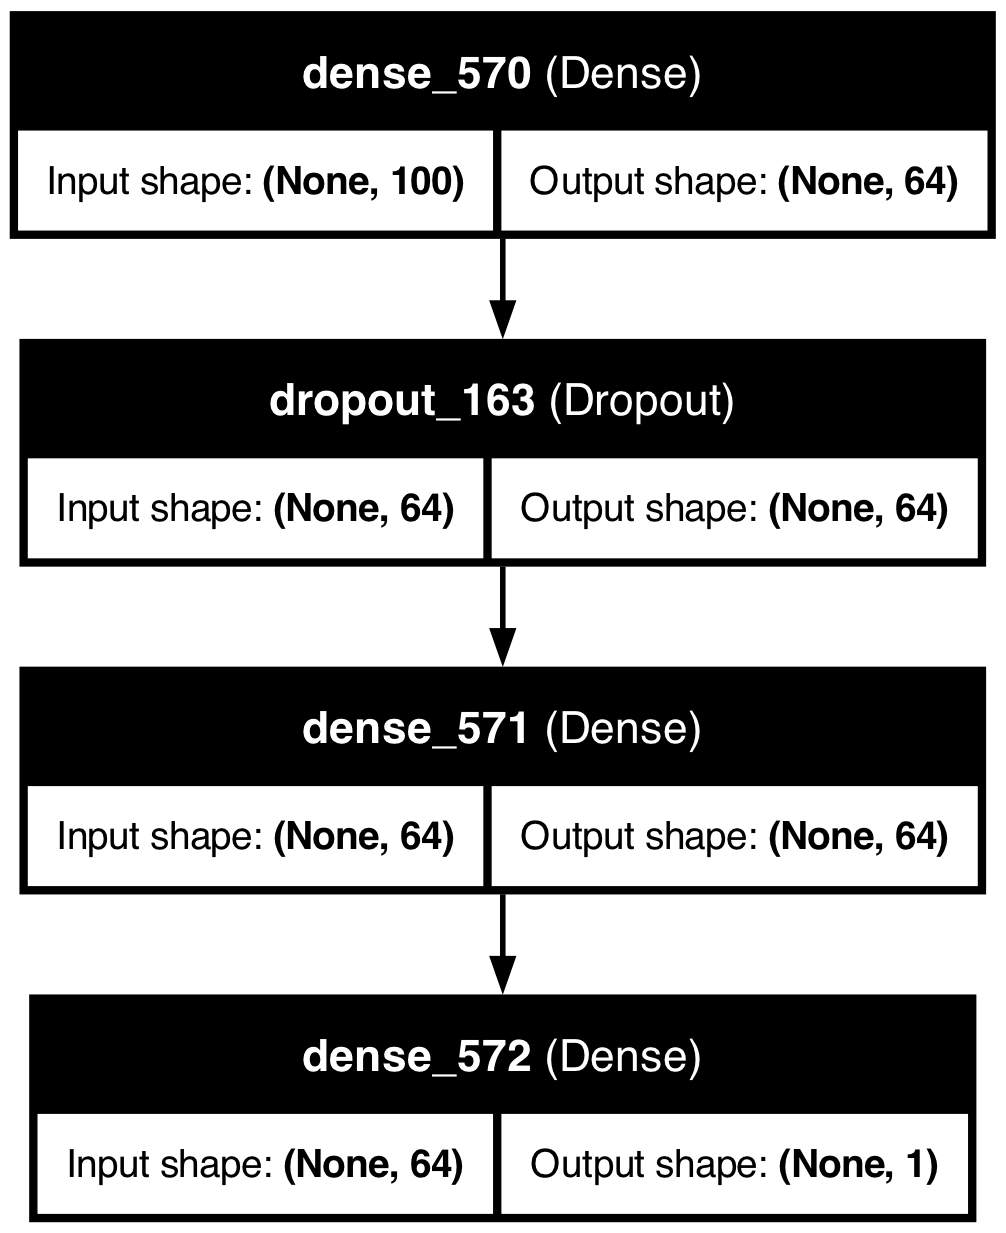

In [30]:
from tensorflow.keras.utils import plot_model
import pydot

# Generate the plot
plot_model(model_1c, to_file='model_1c_network.png', show_shapes=True, show_layer_names=True)


In [31]:
model_1c.compile(
    optimizer=best_params['optimizer'],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    verbose=1, 
    min_lr=0.001
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [36]:
model_1c_history = model_1c.fit(
    cX_train_vec, cy_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
239/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6927 - loss: 0.5850
Epoch 1: val_loss did not improve from 0.55339
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6929 - loss: 0.5847 - val_accuracy: 0.6960 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 2/50
201/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7011 - loss: 0.5693
Epoch 2: val_loss did not improve from 0.55339
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6996 - loss: 0.5703 - val_accuracy: 0.6995 - val_loss: 0.5583 - learning_rate: 0.0010
Epoch 3/50
208/248 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6955 - loss: 0.5767
Epoch 3: val_loss did not improve from 0.55339
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6955 - loss: 0.5766 - val_accuracy: 0.6808 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 4/50
234/248 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.6932 - loss: 0.5732
Epoch 4: val_loss did not improve from 0.55339
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

In [38]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1c.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1c_time_per_instance = (end_time - start_time) / len(cX_test_vec)

# Calculate accuracy, precision, recall, and f1 score
m1c_accuracy = accuracy_score(cy_test, cy_pred)
m1c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1c_recall = recall_score(cy_test, cy_pred, average='weighted')
m1c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1c_accuracy:.2%}", f"{m1c_precision:.3f}", f"{m1c_recall:.3f}", f"{m1c_f1:.3f}", f"{m1c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Performance          Results
         accuracy           69.62%
        precision            0.732
           recall            0.696
         f1_score            0.684
    time/instance 0.000208 seconds


In [39]:
store_results('Model_1c', m1c_accuracy, m1c_precision, m1c_recall, m1c_f1, m1c_time_per_instance)

# View the consolidated results
print(results_df)

      Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0c   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1c   69.62%     0.732  0.696    0.684  0.000208 seconds
